In [17]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
data_path: str = "data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)
df

,ID,target,_type
0,2023-01-01 00:00:00,2.0,train
1,2023-01-01 01:00:00,1.0,train
2,2023-01-01 02:00:00,1.0,train
3,2023-01-01 03:00:00,1.0,train
4,2023-01-01 04:00:00,2.0,train
...,...,...,...
2787,2024-04-26 03:00:00,NaN,test
2788,2024-04-26 04:00:00,NaN,test
2789,2024-04-26 05:00:00,NaN,test
2790,2024-04-26 06:00:00,NaN,test


In [6]:
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 62.04it/s]


In [7]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_open-interest_ftx_all_symbol_open_interest                100.0
hourly_market-data_open-interest_okx_open_interest                           100.0
hourly_market-data_liquidations_okex_btc_usd_short_liquidations              100.0
hourly_market-data_liquidations_okex_btc_usd_long_liquidations_usd           100.0
hourly_market-data_liquidations_okex_btc_usd_short_liquidations_usd          100.0
                                                                             ...  
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio      0.0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio          0.0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio           0.0
target                                                                         0.0
hourly_market-data_open-interest_htx_global_btc_usdt_open_interest             0.0
Length: 255, dtype: float64

In [9]:
df.columns

Index(['ID', 'target', '_type',
       'hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations',
       'hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations',
       'hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations_usd',
       'hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations_usd',
       'hourly_market-data_open-interest_ftx_btc_usd_open_interest',
       'hourly_market-data_open-interest_bybit_open_interest',
       'hourly_market-data_funding-rates_bybit_funding_rates',
       ...
       'hourly_market-data_liquidations_ftx_btc_usd_short_liquidations_usd',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_short_liquidations',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_short_liquidations_usd',
       'hourly_market

In [10]:
cols_dict_open_interest = {}
for i in df.columns:
    parts=i.split("_")
    if len(parts)>=3 and "market-data" in parts and "open-interest" in parts:
        cols_dict_open_interest[i]="_".join(parts[2:])
    elif len(parts)<3:
        cols_dict_open_interest[i]=i
cols_dict_funding_rates ={}
for i in df.columns:
    parts=i.split("_")
    if len(parts)>=3 and "market-data" in parts and "funding-rates" in parts:
        cols_dict_funding_rates[i]="_".join(parts[2:])
    elif len(parts)<3:
        cols_dict_funding_rates[i]=i
cols_dict_open_interest

{'ID': 'ID',
 'target': 'target',
 '_type': '_type',
 'hourly_market-data_open-interest_ftx_btc_usd_open_interest': 'open-interest_ftx_btc_usd_open_interest',
 'hourly_market-data_open-interest_bybit_open_interest': 'open-interest_bybit_open_interest',
 'hourly_market-data_open-interest_binance_btc_busd_open_interest': 'open-interest_binance_btc_busd_open_interest',
 'hourly_market-data_open-interest_kraken_open_interest': 'open-interest_kraken_open_interest',
 'hourly_market-data_open-interest_okx_open_interest': 'open-interest_okx_open_interest',
 'hourly_market-data_open-interest_deribit_open_interest': 'open-interest_deribit_open_interest',
 'hourly_market-data_open-interest_deribit_btc_usd_open_interest': 'open-interest_deribit_btc_usd_open_interest',
 'hourly_market-data_open-interest_bitfinex_open_interest': 'open-interest_bitfinex_open_interest',
 'hourly_market-data_open-interest_huobi_global_btc_usd_open_interest': 'open-interest_huobi_global_btc_usd_open_interest',
 'hourly_

In [12]:
eda_exp1=df[cols_dict_open_interest.keys()].rename(cols_dict_open_interest, axis=1)
eda_exp1=eda_exp1[eda_exp1['_type']=='train']

In [13]:
missing_values=eda_exp1.isnull().sum()
missing_values
for i in eda_exp1.columns:
    if missing_values[i]==8760:
        eda_exp1=eda_exp1.drop(columns=i)
eda_exp1.isnull().sum()

ID                                                      0
target                                                  0
_type                                                   0
open-interest_binance_btc_busd_open_interest           88
open-interest_deribit_btc_usd_open_interest             8
open-interest_huobi_global_btc_usd_open_interest        7
open-interest_htx_global_all_symbol_open_interest       0
open-interest_bitmex_btc_usd_open_interest              1
open-interest_gate_io_all_symbol_open_interest          1
open-interest_bitfinex_btc_usdt_open_interest           1
open-interest_bitmex_all_symbol_open_interest           1
open-interest_bybit_btc_usd_open_interest               1
open-interest_okx_btc_usd_open_interest                 7
open-interest_bybit_btc_usdt_open_interest              1
open-interest_binance_all_symbol_open_interest          0
open-interest_kraken_all_symbol_open_interest           7
open-interest_all_exchange_all_symbol_open_interest     0
open-interest_

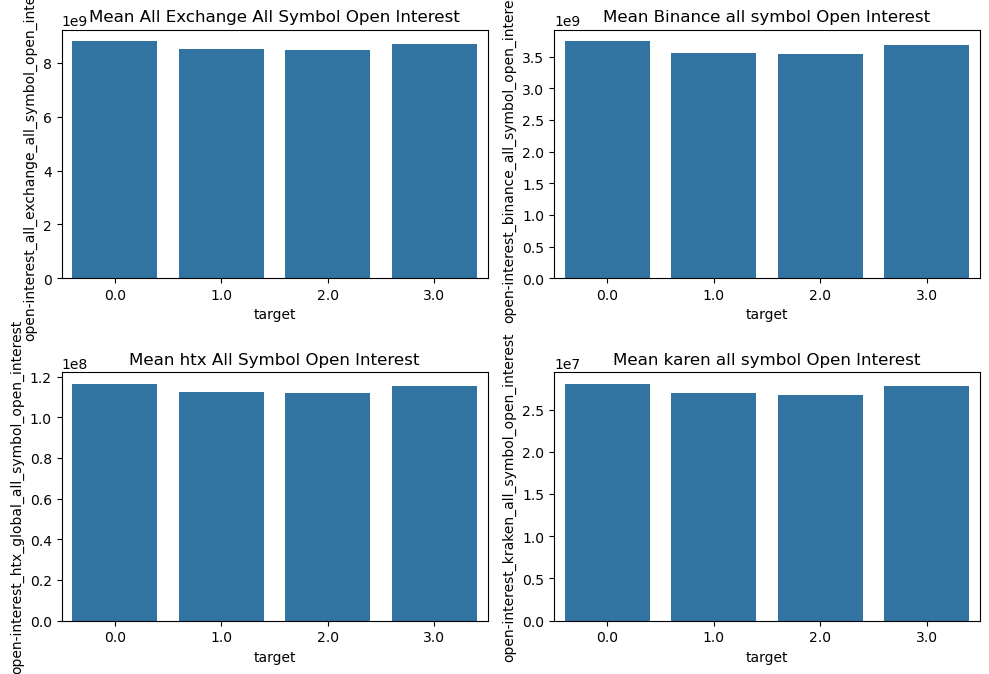

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Grouping data by 'target' and calculating mean
eda_group = eda_exp1.groupby("target")[['open-interest_all_exchange_all_symbol_open_interest',
                                        'open-interest_htx_global_all_symbol_open_interest',
                                        'open-interest_binance_all_symbol_open_interest',
                                        'open-interest_kraken_all_symbol_open_interest',
                                        'open-interest_bitfinex_all_symbol_open_interest',
                                       'open-interest_huobi_global_all_symbol_open_interest',
                                       'open-interest_okx_all_symbol_open_interest',
                                       'open-interest_deribit_all_symbol_open_interest']].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()  # Flatten the axes for easier iteration

# Plotting the bar plots
sns.barplot(x='target', y='open-interest_all_exchange_all_symbol_open_interest', ax=axes[0], data=eda_group)
axes[0].set_title('Mean All Exchange All Symbol Open Interest')

sns.barplot(x='target', y='open-interest_binance_all_symbol_open_interest', ax=axes[1], data=eda_group)
axes[1].set_title('Mean Binance all symbol Open Interest')

sns.barplot(x='target', y='open-interest_htx_global_all_symbol_open_interest', ax=axes[2], data=eda_group)
axes[2].set_title('Mean htx All Symbol Open Interest')

sns.barplot(x='target', y='open-interest_kraken_all_symbol_open_interest', ax=axes[3], data=eda_group)
axes[3].set_title('Mean karen all symbol Open Interest')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# check for open interest for all exchanges and all symbols between the others by grouping targets 

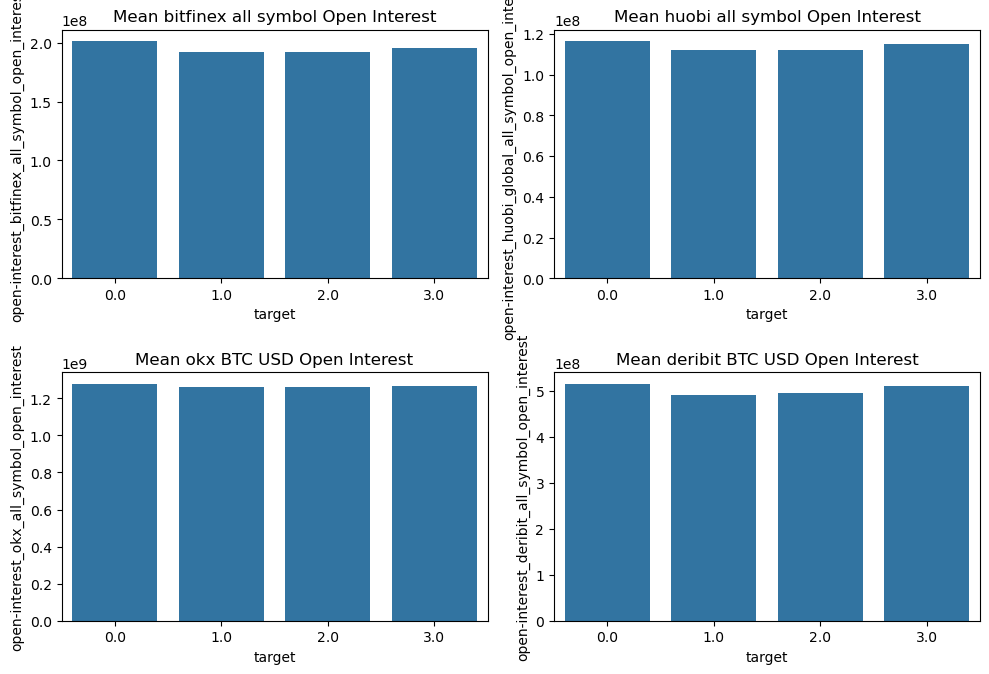

<Axes: xlabel='target', ylabel='diff_overall_okx'>

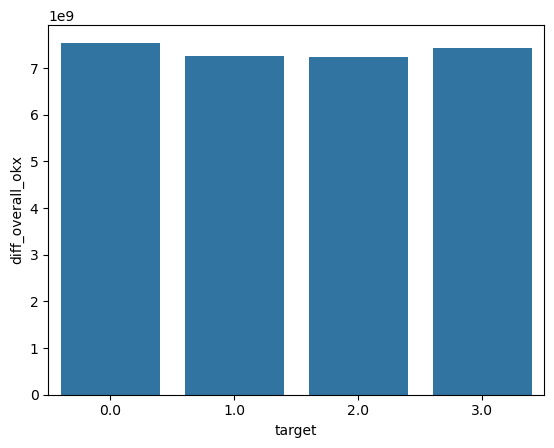

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()  # Flatten the axes for easier iteration
sns.barplot(x='target', y='open-interest_bitfinex_all_symbol_open_interest', ax=axes[0], data=eda_group)
axes[0].set_title('Mean bitfinex all symbol Open Interest')
sns.barplot(x='target', y='open-interest_huobi_global_all_symbol_open_interest', ax=axes[1], data=eda_group)
axes[1].set_title('Mean huobi all symbol Open Interest')
sns.barplot(x='target', y='open-interest_okx_all_symbol_open_interest', ax=axes[2], data=eda_group)
axes[2].set_title('Mean okx BTC USD Open Interest')
sns.barplot(x='target', y='open-interest_deribit_all_symbol_open_interest', ax=axes[3], data=eda_group)
axes[3].set_title('Mean deribit BTC USD Open Interest')
plt.tight_layout()
plt.show()

eda_exp1=eda_exp1.assign(
    diff_overall_okx=eda_exp1['open-interest_all_exchange_all_symbol_open_interest']-eda_exp1['open-interest_okx_all_symbol_open_interest']
)

t=eda_exp1.groupby('target')['diff_overall_okx'].mean().reset_index()
sns.barplot(x='target',y='diff_overall_okx',data=t)

In [31]:


t=eda_exp1.groupby('target')['diff_overall_okx'].mean().reset_index()
sns.barplot(x='target',y='diff_overall_okx',data=t)

KeyError: 'Column not found: diff_overall_okx'